Analyze 15/134-146 neq switching

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def bound_with_exp(forward_accumulated, reverse_accumulated):
    upper_dg, upper_ddg = pymbar.exp.EXP(forward_accumulated)
    lower_dg, lower_ddg = pymbar.exp.EXP(reverse_accumulated)
    return upper_dg, upper_ddg, lower_dg, lower_ddg
    
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
#     # Substract offset
#     print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()

    return accumulated_forward
    

## 15/145

In [9]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 145
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 145
100
about to save: complex forward
100
about to save: complex reverse
99
about to save: apo forward
99
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/145/145_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/145/145_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/145/145_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/145/145_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  4., 13., 11., 17., 19., 13., 10.,  7.,  5.]),
 array([139.81016081, 142.36907919, 144.92799757, 147.48691595,
        150.04583433, 152.60475271, 155.16367109, 157.72258947,
        160.28150785, 162.84042623, 165.39934461]),
 <BarContainer object of 10 artists>)

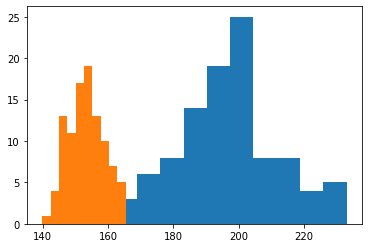

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[-2.24, (-3.65, -0.55)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [10]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

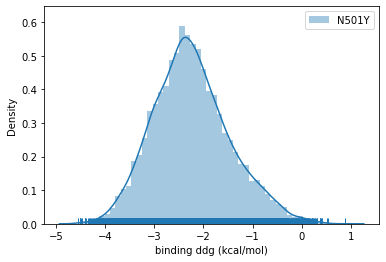

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [11]:
np.std(ddgs[forward])

1.3174039502625758

## 15/146

In [3]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 146
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 146
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/146/146_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/146/146_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/146/146_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/146/146_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 4., 11., 21., 20., 26., 10.,  5.,  0.,  2.,  1.]),
 array([ 81.4921788 ,  84.79715951,  88.10214022,  91.40712093,
         94.71210163,  98.01708234, 101.32206305, 104.62704376,
        107.93202447, 111.23700518, 114.54198588]),
 <BarContainer object of 10 artists>)

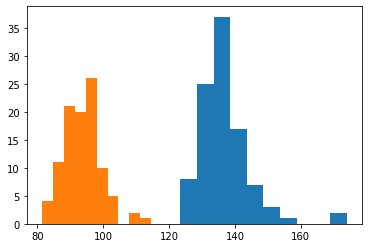

In [12]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [13]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [15]:
output_kcalmol

[4.54, (2.2, 5.7)]

In [16]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [17]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [4]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

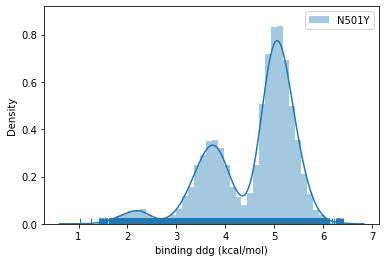

In [18]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [8]:
np.std(ddgs[forward])

1.4872117085920264

## 15/134

In [3]:
# Load data into dicts and plot 
titles = ["N501S"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 134
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("complex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("apo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
    

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 134
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/134/134_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/134/134_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/134/134_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/134/134_apo_work_dist.png
binding DDG:  3.359499580699847  ( 0.5633910370038939 )
complex DG:  98.49563940351496  ( 0.503299089014435 )
apo DG:  95.13613982281511  ( 0.25317876604005085 )
binding DDG (upper):  3.3409375666255414  ( 0.5945955969842197 )
complex DG:  99.1201173110249  ( 0.41050035916620414 )
apo DG:  95.77917974439936  ( 0.4301550639913914 )
binding DDG (lower):  6.903281903543288  ( -0.7126336714226951 )
complex DG:  101.98478033916643  ( -0.5765696

<Figure size 432x288 with 0 Axes>

(array([ 8., 18., 35., 24.,  9.,  3.,  1.,  0.,  1.,  1.]),
 array([141.46855536, 144.88627646, 148.30399757, 151.72171868,
        155.13943978, 158.55716089, 161.974882  , 165.3926031 ,
        168.81032421, 172.22804532, 175.64576643]),
 <BarContainer object of 10 artists>)

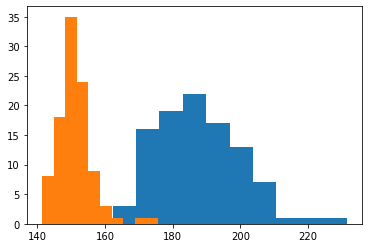

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[3.72, (1.08, 6.97)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [10]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

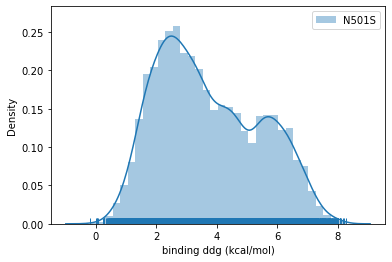

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [12]:
np.std(np.array(ddgs[forward])*KT_KCALMOL)

1.6939032508186243

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[95.14, (94.6, 95.71)]

In [15]:
output_kcalmol_complex

[98.86, (96.33, 102.08)]

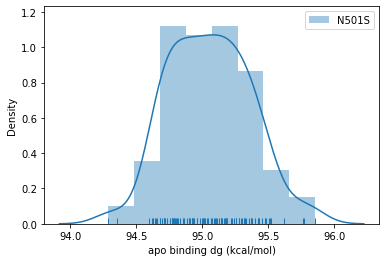

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

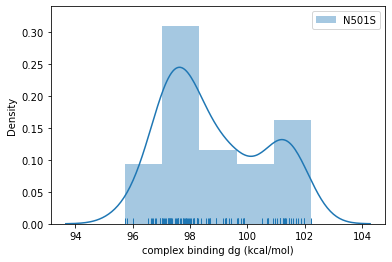

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/135

In [18]:
# Load data into dicts and plot 
titles = ["N501T"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 135
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("\tapo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
     

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 135
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/135/135_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/135/135_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/135/135_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/135/135_apo_work_dist.png
binding DDG:  3.4450571653018898  ( 0.6707700196344761 )
	complex DG:  99.38428964571035  ( 0.6283718178262404 )
	apo DG:  95.93923248040846  ( 0.2346940088757736 )
binding DDG (upper):  8.636265159118693  ( 0.5376973887648369 )
	complex DG:  104.05268918969601  ( 0.31226943889192743 )
	apo DG:  95.41642403057732  ( 0.43772854535504635 )
binding DDG (lower):  -0.2324521660506491  ( -0.592054096421978 )
	complex DG:  94.72946437485554  ( -0

<Figure size 432x288 with 0 Axes>

(array([ 2.,  2.,  3., 20., 23., 19., 19.,  8.,  2.,  2.]),
 array([132.26128322, 135.37731237, 138.49334151, 141.60937066,
        144.72539981, 147.84142896, 150.95745811, 154.07348725,
        157.1895164 , 160.30554555, 163.4215747 ]),
 <BarContainer object of 10 artists>)

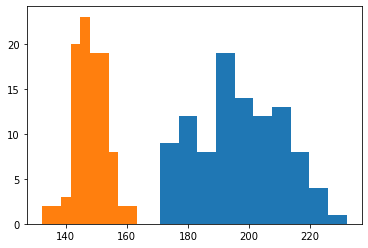

In [19]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [20]:
np.min(d_works['complex']['forward'])

170.80324941592752

In [21]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [23]:
output_kcalmol

[3.22, (1.78, 4.27)]

In [24]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [25]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [26]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

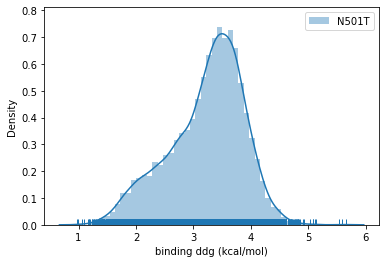

In [27]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [28]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.6535014759993814

In [29]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [30]:
output_kcalmol_apo

[95.94, (95.37, 96.46)]

In [31]:
output_kcalmol_complex

[99.16, (97.85, 99.99)]

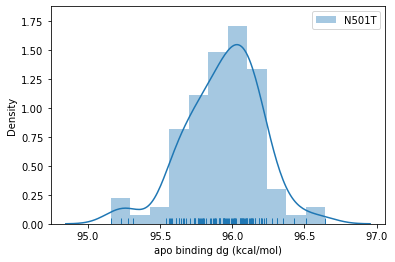

In [32]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

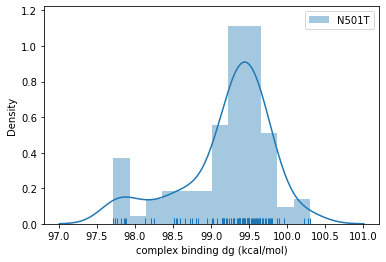

In [33]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/137

In [34]:
# Load data into dicts and plot 
titles = ["N501Q"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 137
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 137
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/137/137_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/137/137_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/137/137_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/137/137_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  3.,  2.,  9., 12., 16., 16., 20., 13.,  8.]),
 array([ 1.40275145,  4.00700414,  6.61125683,  9.21550953, 11.81976222,
        14.42401492, 17.02826761, 19.6325203 , 22.236773  , 24.84102569,
        27.44527839]),
 <BarContainer object of 10 artists>)

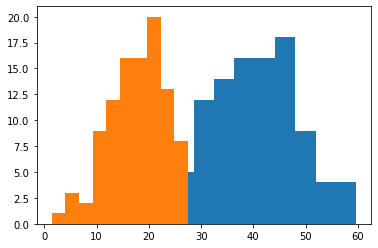

In [35]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [36]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [38]:
output_kcalmol

[1.78, (0.92, 2.54)]

In [39]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [40]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [41]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

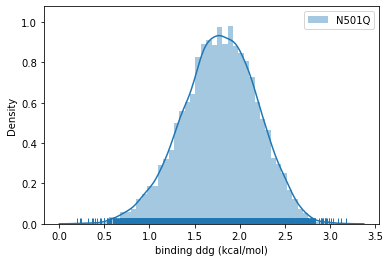

In [42]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [43]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.4139050669109896

In [44]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [45]:
output_kcalmol_apo

[14.04, (13.62, 14.47)]

In [46]:
output_kcalmol_complex

[15.82, (15.08, 16.46)]

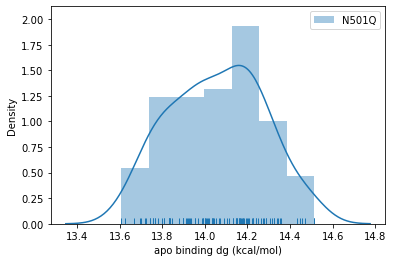

In [47]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

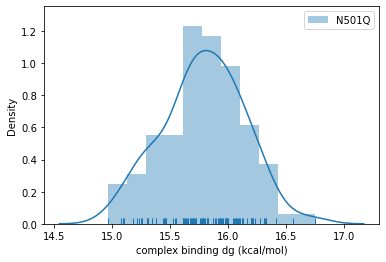

In [48]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/138

In [49]:
# Load data into dicts and plot 
titles = ["N501C"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 138
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 138
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/138/138_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/138/138_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/138/138_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/138/138_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  4.,  3., 12., 11., 24., 19., 12., 10.,  4.]),
 array([112.77971647, 115.33426224, 117.888808  , 120.44335377,
        122.99789953, 125.5524453 , 128.10699106, 130.66153683,
        133.2160826 , 135.77062836, 138.32517413]),
 <BarContainer object of 10 artists>)

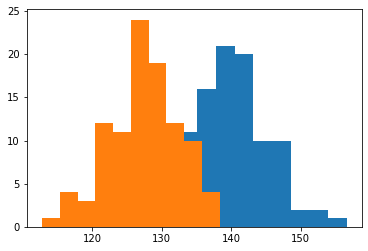

In [50]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [51]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [52]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [53]:
output_kcalmol

[-1.63, (-2.21, -1.06)]

In [54]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [55]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [56]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

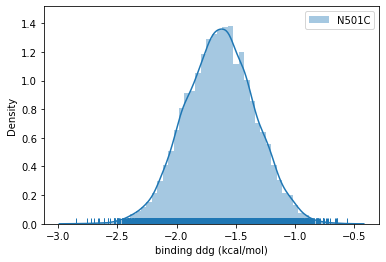

In [57]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [58]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.292911242108072

In [59]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [60]:
output_kcalmol_apo

[81.27, (81.07, 81.47)]

In [61]:
output_kcalmol_complex

[79.63, (79.09, 80.16)]

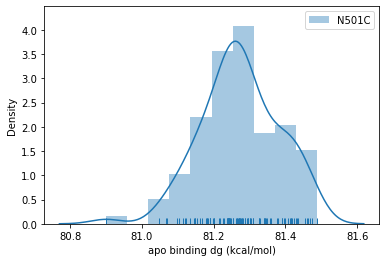

In [62]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

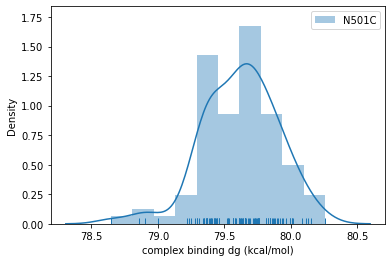

In [63]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/139

In [64]:
# Load data into dicts and plot 
titles = ["N501G"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 139
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 139
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/139/139_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/139/139_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/139/139_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/139/139_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  4.,  3.,  3.,  6., 11., 13., 24., 22., 13.]),
 array([ 83.88082801,  87.20940846,  90.53798891,  93.86656936,
         97.19514981, 100.52373027, 103.85231072, 107.18089117,
        110.50947162, 113.83805207, 117.16663253]),
 <BarContainer object of 10 artists>)

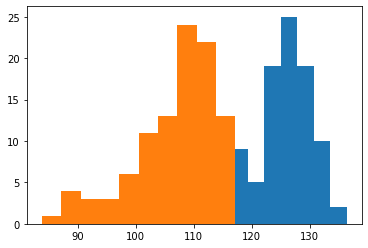

In [65]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [66]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [67]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [68]:
output_kcalmol

[3.31, (2.69, 3.94)]

In [69]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [70]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [71]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

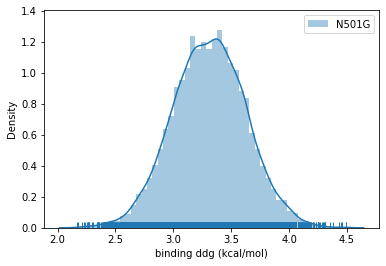

In [72]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [73]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.31655953986476015

In [74]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [75]:
output_kcalmol_apo

[65.35, (64.99, 65.71)]

In [76]:
output_kcalmol_complex

[68.66, (68.16, 69.16)]

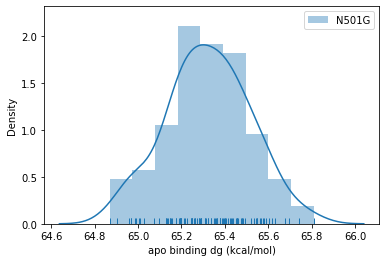

In [77]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

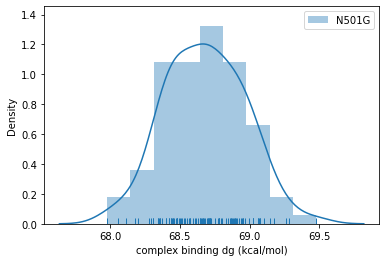

In [78]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/140

In [79]:
# Load data into dicts and plot 
titles = ["N501R"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 140
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 140
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/140/140_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/140/140_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/140/140_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/140/140_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 3.,  0.,  6., 10.,  9., 24., 20., 15., 10.,  3.]),
 array([-350.23158908, -345.45785532, -340.68412156, -335.9103878 ,
        -331.13665403, -326.36292027, -321.58918651, -316.81545275,
        -312.04171899, -307.26798522, -302.49425146]),
 <BarContainer object of 10 artists>)

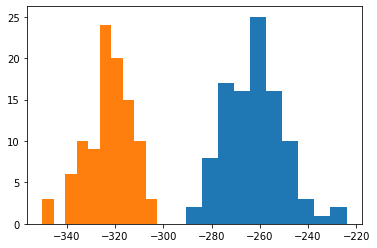

In [80]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [81]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [82]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [83]:
output_kcalmol

[-1.8, (-3.23, 0.66)]

In [84]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [85]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [86]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

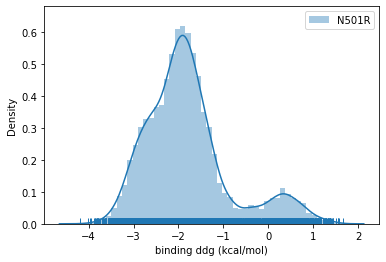

In [87]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [88]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.9575590114859657

In [89]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [90]:
output_kcalmol_apo

[-174.94, (-175.42, -174.49)]

In [91]:
output_kcalmol_complex

[-176.74, (-178.04, -174.32)]

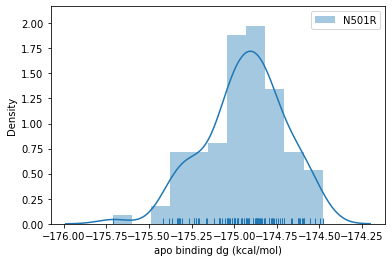

In [92]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

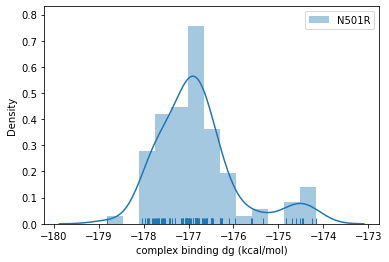

In [93]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/141

In [158]:
# Load data into dicts and plot 
titles = ["N501H"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 141
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 141
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/141/141_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/141/141_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/141/141_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/141/141_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  4.,  5., 14., 15., 22., 14., 14.,  7.,  4.]),
 array([ 74.795278  ,  78.62345268,  82.45162735,  86.27980203,
         90.10797671,  93.93615138,  97.76432606, 101.59250074,
        105.42067542, 109.24885009, 113.07702477]),
 <BarContainer object of 10 artists>)

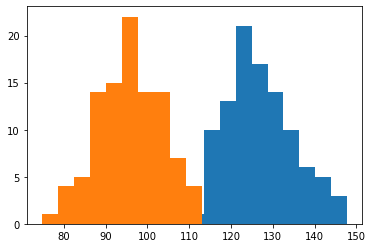

In [95]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [96]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [97]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [98]:
output_kcalmol

[-0.11, (-1.45, 0.82)]

In [99]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [100]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [159]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

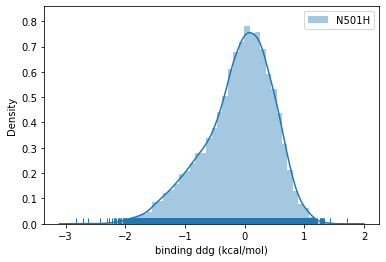

In [102]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [162]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.5876288381676587

In [104]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [105]:
output_kcalmol_apo

[67.12, (66.78, 67.45)]

In [106]:
output_kcalmol_complex

[67.0, (65.69, 67.86)]

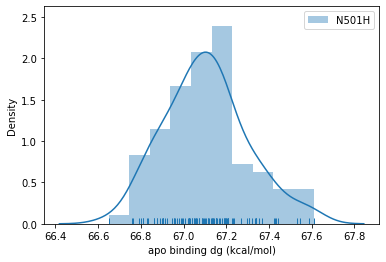

In [107]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

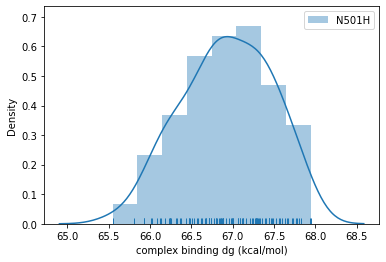

In [108]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/142

In [163]:
# Load data into dicts and plot 
titles = ["N501K"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 142
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 142
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/142/142_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/142/142_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/142/142_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/142/142_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  0.,  0.,  3., 13., 12., 26., 26.,  8., 11.]),
 array([-78.65052558, -73.40473103, -68.15893648, -62.91314193,
        -57.66734738, -52.42155282, -47.17575827, -41.92996372,
        -36.68416917, -31.43837462, -26.19258007]),
 <BarContainer object of 10 artists>)

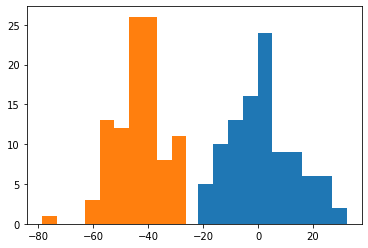

In [110]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [111]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [112]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [113]:
output_kcalmol

[1.9, (1.1, 2.91)]

In [114]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [115]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [164]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

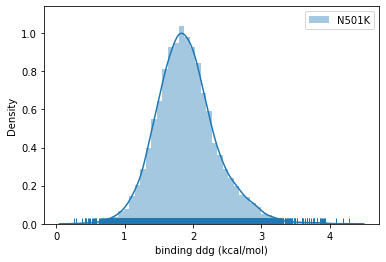

In [117]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [166]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.4490190159266184

In [119]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [120]:
output_kcalmol_apo

[-15.95, (-16.38, -15.5)]

In [121]:
output_kcalmol_complex

[-14.05, (-14.68, -13.14)]

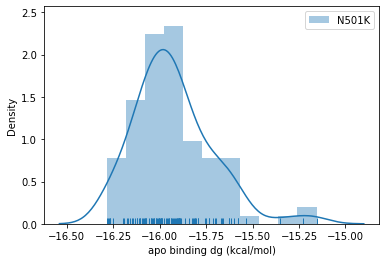

In [122]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

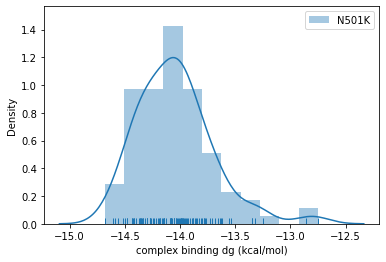

In [123]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/143

In [124]:
# Load data into dicts and plot 
titles = ["N501D"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 143
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 143
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/143/143_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/143/143_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/143/143_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/143/143_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 5.,  4., 17., 18., 15., 14., 16.,  5.,  2.,  4.]),
 array([-163.75246255, -160.11043213, -156.46840171, -152.82637128,
        -149.18434086, -145.54231044, -141.90028002, -138.2582496 ,
        -134.61621918, -130.97418876, -127.33215834]),
 <BarContainer object of 10 artists>)

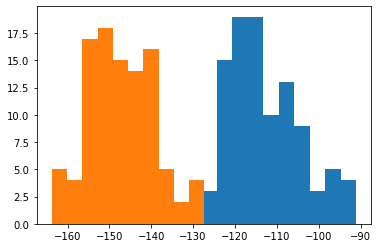

In [125]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [126]:
np.std(d_works['complex']['forward'])

8.483298222828601

In [127]:
np.std(d_works['complex']['reverse']*-1)

7.909447361222212

In [128]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [129]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [130]:
output_kcalmol

[5.93, (4.87, 6.67)]

In [131]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [132]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [133]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

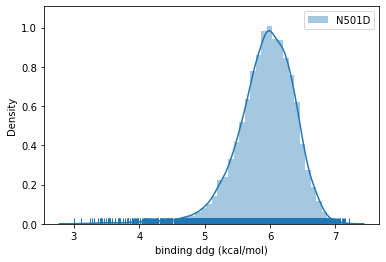

In [134]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [135]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.46224138276474597

In [136]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [137]:
output_kcalmol_apo

[-81.81, (-82.08, -81.54)]

In [138]:
output_kcalmol_complex

[-75.88, (-76.88, -75.21)]

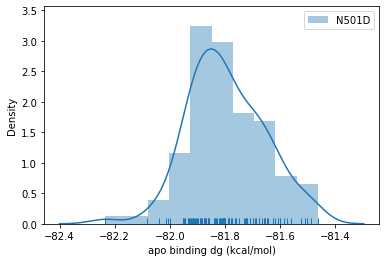

In [139]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

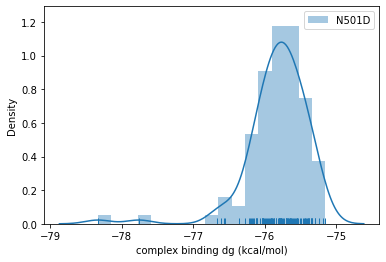

In [140]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/144

In [167]:
# Load data into dicts and plot 
titles = ["N501E"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 144
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 144
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/144/144_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/144/144_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/144/144_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/144/144_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 2.,  5., 23., 19., 14., 14., 12.,  5.,  3.,  3.]),
 array([-156.77821598, -152.3968786 , -148.01554123, -143.63420385,
        -139.25286648, -134.8715291 , -130.49019173, -126.10885435,
        -121.72751698, -117.3461796 , -112.96484223]),
 <BarContainer object of 10 artists>)

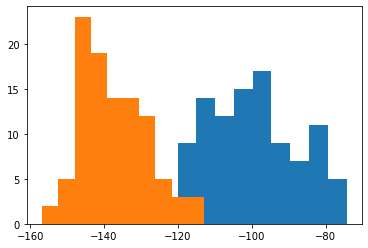

In [142]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [143]:
np.std(d_works['complex']['forward'])

12.030037105077733

In [144]:
np.std(d_works['complex']['reverse']*-1)

9.161534892724262

In [145]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [146]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [147]:
output_kcalmol

[8.02, (6.4, 9.54)]

In [148]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [149]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [168]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

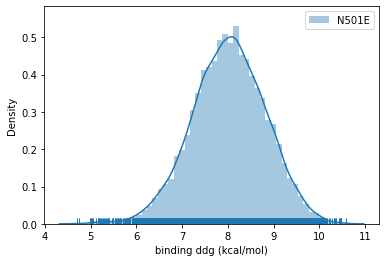

In [151]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [169]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.8023044463876072

In [153]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [154]:
output_kcalmol_apo

[-78.66, (-79.16, -78.15)]

In [155]:
output_kcalmol_complex

[-70.64, (-72.18, -69.23)]

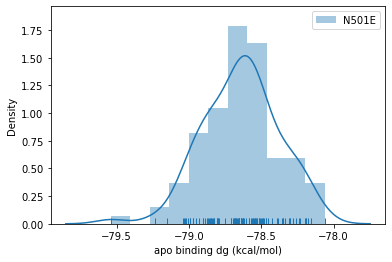

In [156]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

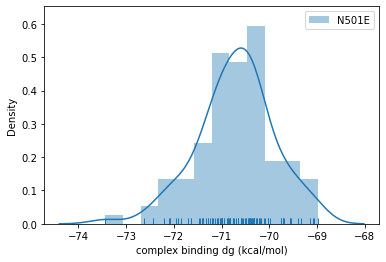

In [157]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()